In [57]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt
from time import time, sleep
import os

from torch.optim import Adam, SGD

from PoisDenoiser.utils import show_images as show

from PoisDenoiser.networks.PoisNet.net import PoisNet
from PoisDenoiser.dataset_loader import BSDS500
from torch.utils.data import DataLoader
import os

gpu_id=1
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id)

from IPython.display import clear_output
% matplotlib inline


def show_losses(flag_while=False, s=1, c=8, log=False, \
                path2folder='./PoisDenoiser/networks/PoisNet/models/',\
                last_epochs=5):
    exp_name = 's{}c{}_wtf'.format(s, c)
    path2folder += exp_name+'/'

    while True:
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        train = np.load(path2folder+'train_losses.npy')
        val = np.load(path2folder+'val_losses.npy')

        num_epochs = np.load(path2folder+'epoch.npy')
        
        train_x = np.linspace(0, num_epochs, num=len(train))
        val_x = np.linspace(0, num_epochs, num=len(val))
        
        train_x_last = int(len(train)/num_epochs*(num_epochs-last_epochs-1))
        val_x_last = int(len(val)/num_epochs*(num_epochs-last_epochs-1))
        
        if log:
            ax[0].semilogy(train_x, train)
            ax[0].semilogy(val_x, val)
            ax[1].semilogy(train_x[train_x_last:], train[train_x_last:])
            ax[1].semilogy(val_x[val_x_last:], val[val_x_last:])
        else:
            ax[0].plot(train_x, train)
            ax[0].plot(val_x, val)
            ax[1].plot(train_x[train_x_last:], train[train_x_last:])
            ax[1].plot(val_x[val_x_last:], val[val_x_last:])
            
        # show only last last_epochs epochs
        ax[1].set_xlim((np.maximum(num_epochs-last_epochs, 0), num_epochs))
        min_y = np.minimum(train[train_x_last:].min(), val[val_x_last:].min())*0.9
        max_y = np.maximum(train[train_x_last:].max(), val[val_x_last:].max())*1.1

        ax[1].set_ylim(min_y, max_y)
        ax[0].set_title('min train= {:.5f} | min val= {:.5f}'.format(min(train), min(val)))
        ax[1].set_title('last train= {:.5f} | last val= {:.5f}'.format(train[-1], val[-1]))
        plt.show()
        if flag_while:
            sleep(2)
            clear_output() 
        else:
            break

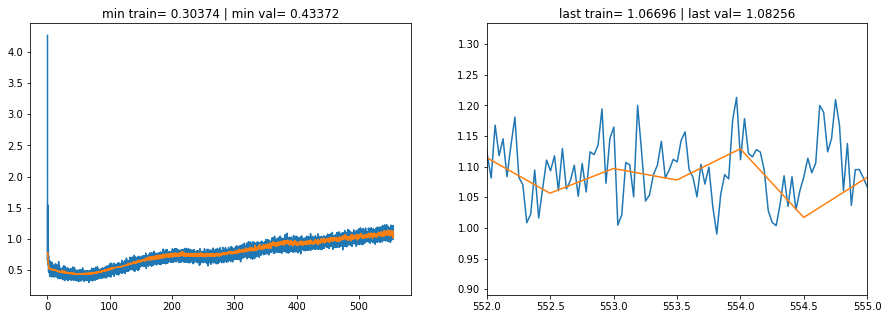

In [59]:
s=5
c=64

flag_while = False
log = False

show_losses(flag_while=flag_while, s=s, c=c, log=log, last_epochs=3)

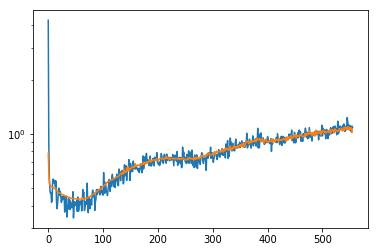

In [101]:
s=5
c=64

path2folder='./PoisDenoiser/networks/PoisNet/models/'
exp_name = 's{}c{}_wtf'.format(s, c)
path2folder += exp_name+'/'
val = np.load(path2folder+'val_losses.npy')
train = np.load(path2folder+'train_losses.npy')

plt.semilogy(train[::32])
plt.semilogy(val[::2])


In [61]:
s=5
c=64

path2folder='./PoisDenoiser/networks/PoisNet/models/'
exp_name = 's{}c{}_wtf'.format(s, c)
path2folder += exp_name+'/'
poisprox_outs = np.load(path2folder+'PoisProx_output.npy')
poisprox_ins = np.load(path2folder+'PoisProx_input.npy')

grbf_outs = np.load(path2folder+'grbf_output.npy')
grbf_ins = np.load(path2folder+'grbf_input.npy')

# plt.plot(val[:])

In [64]:
model = PoisNet(output_features=c, stages=s).cuda()

path2dataset = './DATASETS/BSDS500_Pois_crops/'
BSDSval = BSDS500(path2dataset+'val/')
BSDSval_loader = DataLoader(BSDSval, batch_size=5, shuffle=False, num_workers=1)

BSDStrain = BSDS500(path2dataset+'train/')
BSDStrain_loader = DataLoader(BSDStrain, batch_size=5, shuffle=False, num_workers=1)

for gt, noisy in BSDSval_loader:
    break

gt = gt.cuda()
noisy = noisy.cuda()

In [97]:
state = th.load('./PoisDenoiser/networks/PoisNet/models/'+exp_name+'/state_555.pth',\
               map_location=lambda storage,loc:storage.cuda())

model.load_state_dict(state['model_state_dict'])

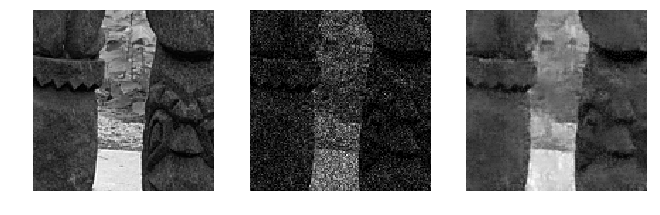

In [98]:
ind = 0
show([gt[ind].unsqueeze(0), noisy[ind].unsqueeze(0), model(noisy[ind].unsqueeze(0),noisy[ind].unsqueeze(0)).detach()])

In [2]:
state = th.load('./PoisDenoiser/networks/PoisNet/models/s1c8_wtf/newton_ERROR.pth')
print(state.keys())

x = state['x']
y = state['y']
alpha = state['alpha']

print(x.size(), x.size(), y.size(), alpha.size())

KeyboardInterrupt: 

In [30]:
from PoisDenoiser.projection_utils import is_in_C, newton, g, f, df

In [31]:
cond_mask = is_in_C(x,y)
newton_res = newton(x,y,cond_mask,num_iters=2)

NEWTON GIVES NAN ALPHA!!!


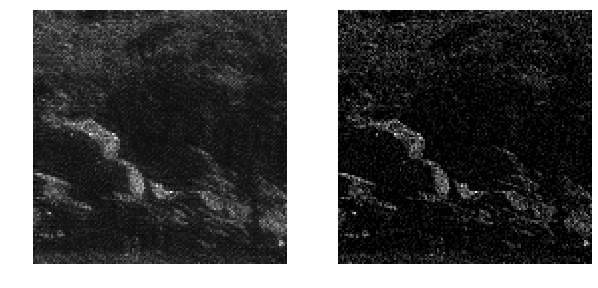

In [32]:
show([x[23].detach(), y[23].detach()])

In [39]:
a_cond = th.Tensor([0]).type_as(x)   

x = state['x'][23].unsqueeze(0)
y = state['y'][23].unsqueeze(0)
batch_size = x.size(0)
alpha = th.zeros((batch_size, 1,1,1)).type_as(x)
cond_mask = is_in_C(x,y)

f_val = f(g(x,y,alpha=alpha)[0], y, a_cond=a_cond)

for _ in range(2):
    df_val = df(x,y,alpha=alpha.clone())
    print(df_val)
    break
    alpha -= (f_val/df_val).view(-1, 1,1,1) # f_val > 0, df_val < 0 !!!
    print(f_val, df_val)
    f_val = f( g(x,y,alpha=alpha.clone())[0], y, a_cond=a_cond)

alpha[cond_mask] = 0

if th.isnan(alpha).sum() > 0:
    print('NEWTON GIVES NAN ALPHA!!!')

tensor([nan], device='cuda:0', grad_fn=<MulBackward>)


In [41]:
batch_size = x.size(0)

x = x.view(batch_size, -1)
y = y.view(batch_size, -1)
alpha = alpha.view(batch_size, -1)

In [56]:
(x-alpha)

tensor([[ 1.1449e+00,  1.1814e+00,  1.6737e+00,  ...,  6.2158e-01,
          4.2066e-01,  8.5619e-01]], device='cuda:0', grad_fn=<ThSubBackward>)

In [34]:
cond_mask

tensor([0], device='cuda:0', dtype=torch.uint8)

In [25]:
cond_mask[23], alpha[23]

(tensor(0, device='cuda:0', dtype=torch.uint8),
 tensor([[[nan]]], device='cuda:0', grad_fn=<SelectBackward>))

In [50]:
alpha_test = alpha+5

In [59]:
cond = is_in_C(x,y).view(-1, 1,1,1)
alpha_test[1-cond]


tensor([], device='cuda:0', grad_fn=<TakeBackward>)

In [47]:
alpha

tensor([[[[ -7.5376]]],


        [[[ -8.1500]]],


        [[[-11.1520]]],


        [[[ -4.8544]]],


        [[[ -8.3996]]],


        [[[ -4.4373]]],


        [[[ -3.6647]]],


        [[[-15.3155]]],


        [[[     nan]]],


        [[[ -9.5730]]],


        [[[ -6.8141]]],


        [[[-11.7221]]],


        [[[-13.7724]]],


        [[[-11.5284]]],


        [[[ -0.4398]]],


        [[[ -0.6620]]],


        [[[ -2.5281]]],


        [[[ -8.2607]]],


        [[[     nan]]],


        [[[ -5.8215]]],


        [[[ -8.5849]]],


        [[[     nan]]],


        [[[-11.6992]]],


        [[[ -7.6808]]],


        [[[ -1.4053]]],


        [[[ -3.7395]]],


        [[[ -6.6703]]],


        [[[ -4.0125]]],


        [[[     nan]]],


        [[[-11.2814]]],


        [[[ -9.0053]]],


        [[[ -6.9316]]],


        [[[ -2.0532]]],


        [[[ -3.7563]]],


        [[[ -0.9693]]],


        [[[ -2.3893]]],


        [[[-14.1890]]],


        [[[-13.5644]]],


        [[[ 

In [23]:
proj, root = g(x,y,th.zeros((batch_size, 1,1,1)).type_as(x))

In [36]:
df_val.min()

tensor(-5687.1758, device='cuda:0', grad_fn=<MinBackward1>)

In [13]:
alpha.max()

tensor(-0.4381, device='cuda:0', grad_fn=<MaxBackward1>)

In [14]:
proj, root = g(x,y,alpha)

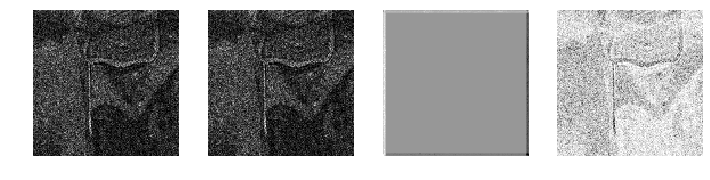

In [16]:
show([x.detach(), y.detach(), proj.detach(), root.detach()])

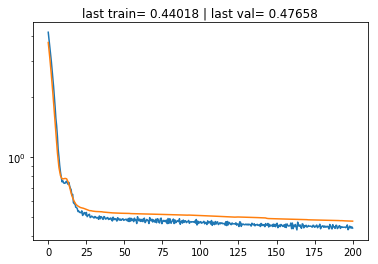

KeyboardInterrupt: 

In [30]:
while True:
# if True:
    path2folder = './PoisDenoiser/networks/PoisNet/models/s1c8/'
    train = np.load(path2folder+'train_losses.npy')
    val = np.load(path2folder+'val_losses.npy')
    
    num_epochs = np.load(path2folder+'epoch.npy')
    
    train_x = np.linspace(0, num_epochs, num=len(train))
    val_x = np.linspace(0, num_epochs, num=len(val))
    

#     plt.plot(train_x, train)
#     plt.plot(val_x, val)
    plt.semilogy(train_x, train)
    plt.semilogy(val_x, val)
    plt.title('last train= {:.5f} | last val= {:.5f}'.format(train[-1], val[-1]))
    plt.show()
    sleep(2)
    clear_output()

In [31]:


model = PoisNet(output_features=8, stages=1).cuda()

path2dataset = './DATASETS/BSDS500_Pois_crops/'
BSDSval = BSDS500(path2dataset+'val/')
BSDSval_loader = DataLoader(BSDSval, batch_size=1, shuffle=False, num_workers=1)

for gt, noisy in BSDSval_loader:
    break

gt = gt.cuda()
noisy = noisy.cuda()

In [34]:
state = th.load('./PoisDenoiser/networks/PoisNet/models/s1c8/state_200.pth',\
               map_location=lambda storage,loc:storage.cuda())

model.load_state_dict(state['model_state_dict'])

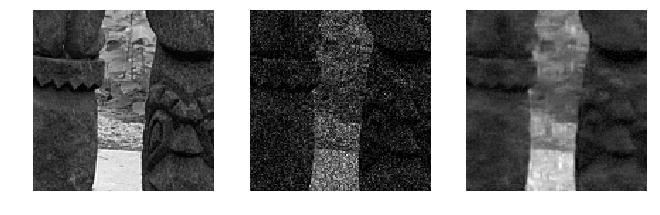

In [35]:
show([gt, noisy, model(noisy,noisy).detach()])

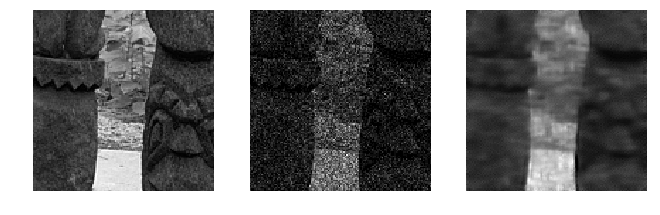

In [36]:
state = th.load('./PoisDenoiser/networks/PoisNet/models/s1c8_wtf/state_120.pth',\
               map_location=lambda storage,loc:storage.cuda())

model.load_state_dict(state['model_state_dict'])

show([gt, noisy, model(noisy,noisy).detach()])

In [5]:
state = th.load('./PoisDenoiser/networks/PoisNet/models/s1c8_wtf/grbf_output_ERROR.pth')
print(state.keys())

grbf_grad_output = state['grad_output']
print(grbf_grad_output.size())

minimums_grbf = []
for i in range(800):
    minimum = grbf_grad_output[i].min().detach().cpu()
    if minimum == -th.Tensor([float('Inf')]):
        minimums_grbf.append(i)

print(minimums_grbf)

dict_keys(['grad_output'])
torch.Size([800, 8, 128, 128])
[5, 6, 10, 21, 24, 31, 33, 46, 47, 52, 53, 57, 72, 73, 76, 85, 86, 87, 89, 99, 104, 111, 114, 124, 125, 134, 142, 145, 154, 160, 162, 167, 175, 186, 191, 198, 213, 215, 217, 219, 227, 233, 237, 246, 256, 263, 274, 279, 287, 299, 304, 312, 318, 322, 328, 331, 336, 338, 350, 351, 352, 355, 358, 359, 362, 381, 383, 385, 388, 393, 404, 415, 417, 418, 425, 428, 430, 437, 442, 446, 453, 458, 460, 462, 463, 472, 480, 484, 487, 491, 505, 512, 514, 516, 521, 527, 533, 539, 558, 566, 574, 578, 584, 588, 589, 591, 593, 598, 604, 607, 609, 614, 627, 629, 635, 636, 642, 651, 666, 674, 677, 680, 685, 687, 689, 694, 700, 701, 702, 707, 720, 721, 723, 732, 733, 759, 761, 763, 772, 773, 782, 794, 796, 797, 799]


In [6]:
state = th.load('./PoisDenoiser/networks/PoisNet/models/s1c8_wtf/padT_grad_input_ERROR.pth')
print(state.keys())

padT_grad_output = state['grad_output']
print(padT_grad_output.size())

minimums_padT = []
for i in range(800):
    minimum = padT_grad_output[i].min().detach().cpu()
    if minimum == -th.Tensor([float('Inf')]):
        minimums_padT.append(i)
print(minimums_padT)

dict_keys(['grad_output', 'pad', 'padType'])
torch.Size([800, 1, 128, 128])
[]


In [7]:
padT_grad_output.min(), padT_grad_output.max(), th.isnan(padT_grad_output).sum()

(tensor(nan, device='cuda:0'),
 tensor(nan, device='cuda:0'),
 tensor(2375680, device='cuda:0'))

In [8]:
nans_padT = []
for i in range(800):
    if th.isnan(padT_grad_output[i]).sum() > 0:
        nans_padT.append(i)
print(nans_padT)

[5, 6, 10, 21, 24, 31, 33, 46, 47, 52, 53, 57, 72, 73, 76, 85, 86, 87, 89, 99, 104, 111, 114, 124, 125, 134, 142, 145, 154, 160, 162, 167, 175, 186, 191, 198, 213, 215, 217, 219, 227, 233, 237, 246, 256, 263, 274, 279, 287, 299, 304, 312, 318, 322, 328, 331, 336, 338, 350, 351, 352, 355, 358, 359, 362, 381, 383, 385, 388, 393, 404, 415, 417, 418, 425, 428, 430, 437, 442, 446, 453, 458, 460, 462, 463, 472, 480, 484, 487, 491, 505, 512, 514, 516, 521, 527, 533, 539, 558, 566, 574, 578, 584, 588, 589, 591, 593, 598, 604, 607, 609, 614, 627, 629, 635, 636, 642, 651, 666, 674, 677, 680, 685, 687, 689, 694, 700, 701, 702, 707, 720, 721, 723, 732, 733, 759, 761, 763, 772, 773, 782, 794, 796, 797, 799]


In [9]:
def cmp(list1, list2):
    if len(list1)== len(list2) and len(list1) == sum([1 for i, j in zip(list1, list2) if i == j]): 
        return True
    else : 
        return False

In [10]:
cmp(nans_padT, minimums_grbf)

True

In [11]:
state = th.load('./PoisDenoiser/networks/PoisNet/models/s1c8_wtf/PoisProx_backward_ERROR.pth')
print(state.keys())

poisProx_grad_output = state['grad_output']
root = state['root']
cond_mask = state['cond_mask']
input_proj = state['input_proj']
print(root.size(), cond_mask.size(), input_proj.size())

dict_keys(['root', 'input_proj', 'cond_mask', 'grad_output'])
torch.Size([800, 1, 128, 128]) torch.Size([800, 1, 1, 1]) torch.Size([800, 1, 128, 128])


In [12]:
nans_root = []
for i in range(800):
    if th.isnan(root[i]).sum() > 0:
        nans_root.append(i)
print(nans_root)

[5, 6, 10, 21, 24, 31, 33, 46, 47, 52, 53, 57, 72, 73, 76, 85, 86, 87, 89, 99, 104, 111, 114, 124, 125, 134, 142, 145, 152, 154, 160, 162, 167, 175, 186, 191, 198, 213, 215, 217, 219, 227, 233, 237, 246, 256, 263, 274, 279, 287, 299, 304, 312, 318, 322, 328, 331, 336, 338, 350, 351, 352, 355, 358, 359, 362, 381, 383, 385, 388, 393, 404, 415, 417, 418, 425, 428, 430, 437, 442, 446, 453, 458, 460, 462, 463, 472, 480, 484, 487, 491, 505, 512, 514, 516, 521, 527, 533, 539, 558, 566, 574, 578, 584, 588, 589, 591, 593, 598, 604, 607, 609, 614, 627, 629, 635, 636, 642, 651, 666, 674, 675, 677, 680, 685, 687, 689, 694, 700, 701, 702, 707, 720, 721, 723, 732, 733, 747, 759, 761, 763, 772, 773, 782, 794, 796, 797, 799]


In [13]:
cmp(nans_padT, nans_root), len(nans_padT), len(nans_root)

(False, 145, 148)

In [14]:
# it is ok because all 3 additional broken roots are not taken into account by cond_mask.

In [15]:
cond_arr = []
for i in range(800):
    if (cond_mask[i]).sum() == 1:
        cond_arr.append(i)
print(cond_arr)

[30, 137, 152, 184, 222, 223, 259, 277, 327, 339, 461, 467, 477, 488, 525, 542, 553, 563, 597, 616, 675, 683, 693, 747, 785]


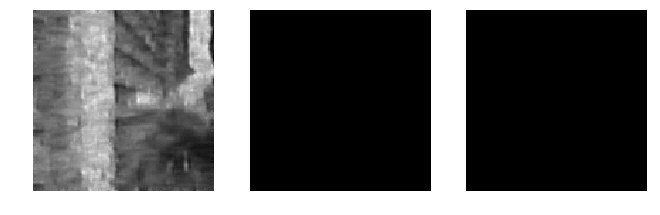

In [16]:
show([input_proj.detach()[0], input_proj.detach()[5],input_proj.detach()[6]])

In [17]:
input_arr = []
for i in range(800):
    if (input_proj[i]).sum() == 0:
        input_arr.append(i)
print(input_arr)

[5, 6, 10, 21, 24, 31, 33, 46, 47, 52, 53, 57, 72, 73, 76, 85, 86, 87, 89, 99, 104, 111, 114, 124, 125, 134, 142, 145, 154, 160, 162, 167, 175, 186, 191, 198, 213, 215, 217, 219, 227, 233, 237, 246, 256, 263, 274, 279, 287, 299, 304, 312, 318, 322, 328, 331, 336, 338, 350, 351, 352, 355, 358, 359, 362, 381, 383, 385, 388, 393, 404, 415, 417, 418, 425, 428, 430, 437, 442, 446, 453, 458, 460, 462, 463, 472, 480, 484, 487, 491, 505, 512, 514, 516, 521, 527, 533, 539, 558, 566, 574, 578, 584, 588, 589, 591, 593, 598, 604, 607, 609, 614, 627, 629, 635, 636, 642, 651, 666, 674, 677, 680, 685, 687, 689, 694, 700, 701, 702, 707, 720, 721, 723, 732, 733, 759, 761, 763, 772, 773, 782, 794, 796, 797, 799]


In [18]:
cmp(input_arr, nans_root), cmp(input_arr, nans_padT)

(False, True)

In [19]:
grad_input = input_proj / root
grad_input[cond_mask.expand_as(grad_input)] = 1
grad_input.mul_(poisProx_grad_output);

grad_input_arr = []
for i in range(800):
    if th.isnan(grad_input[i]).sum() > 0:
        grad_input_arr.append(i)
print(grad_input_arr)

[5, 6, 10, 21, 24, 31, 33, 46, 47, 52, 53, 57, 72, 73, 76, 85, 86, 87, 89, 99, 104, 111, 114, 124, 125, 134, 142, 145, 154, 160, 162, 167, 175, 186, 191, 198, 213, 215, 217, 219, 227, 233, 237, 246, 256, 263, 274, 279, 287, 299, 304, 312, 318, 322, 328, 331, 336, 338, 350, 351, 352, 355, 358, 359, 362, 381, 383, 385, 388, 393, 404, 415, 417, 418, 425, 428, 430, 437, 442, 446, 453, 458, 460, 462, 463, 472, 480, 484, 487, 491, 505, 512, 514, 516, 521, 527, 533, 539, 558, 566, 574, 578, 584, 588, 589, 591, 593, 598, 604, 607, 609, 614, 627, 629, 635, 636, 642, 651, 666, 674, 677, 680, 685, 687, 689, 694, 700, 701, 702, 707, 720, 721, 723, 732, 733, 759, 761, 763, 772, 773, 782, 794, 796, 797, 799]


In [20]:
cmp(grad_input_arr, nans_padT)

True

In [25]:
state = th.load('./PoisDenoiser/networks/PoisNet/models/s1c8_wtf/proj_ERROR.pth')
print(state.keys())

x = state['x']
y = state['y']
alpha = state['alpha']
x_proj = state['x_proj']
proj_root = state['root']

print(proj_root.size(), x.size(), y.size(), alpha.size(), x_proj.size())

dict_keys(['x', 'y', 'alpha', 'root', 'x_proj'])
torch.Size([800, 1, 128, 128]) torch.Size([800, 1, 128, 128]) torch.Size([800, 1, 128, 128]) torch.Size([800, 1, 1, 1]) torch.Size([800, 1, 128, 128])


In [26]:
nans_proj_root = []
for i in range(800):
    if th.isnan(proj_root[i]).sum() > 0:
        nans_proj_root.append(i)
print(nans_proj_root)

[5, 6, 10, 21, 24, 31, 33, 46, 47, 52, 53, 57, 72, 73, 76, 85, 86, 87, 89, 99, 104, 111, 114, 124, 125, 134, 142, 145, 152, 154, 160, 162, 167, 175, 186, 191, 198, 213, 215, 217, 219, 227, 233, 237, 246, 256, 263, 274, 279, 287, 299, 304, 312, 318, 322, 328, 331, 336, 338, 350, 351, 352, 355, 358, 359, 362, 381, 383, 385, 388, 393, 404, 415, 417, 418, 425, 428, 430, 437, 442, 446, 453, 458, 460, 462, 463, 472, 480, 484, 487, 491, 505, 512, 514, 516, 521, 527, 533, 539, 558, 566, 574, 578, 584, 588, 589, 591, 593, 598, 604, 607, 609, 614, 627, 629, 635, 636, 642, 651, 666, 674, 675, 677, 680, 685, 687, 689, 694, 700, 701, 702, 707, 720, 721, 723, 732, 733, 747, 759, 761, 763, 772, 773, 782, 794, 796, 797, 799]


In [30]:
cmp(nans_proj_root, nans_root) # number is greater than errors by number of correct nans

True

In [31]:
nans_x_proj = []
for i in range(800):
    if th.isnan(x_proj[i]).sum() > 0:
        nans_x_proj.append(i)
print(nans_x_proj)

[5, 6, 10, 21, 24, 31, 33, 46, 47, 52, 53, 57, 72, 73, 76, 85, 86, 87, 89, 99, 104, 111, 114, 124, 125, 134, 142, 145, 152, 154, 160, 162, 167, 175, 186, 191, 198, 213, 215, 217, 219, 227, 233, 237, 246, 256, 263, 274, 279, 287, 299, 304, 312, 318, 322, 328, 331, 336, 338, 350, 351, 352, 355, 358, 359, 362, 381, 383, 385, 388, 393, 404, 415, 417, 418, 425, 428, 430, 437, 442, 446, 453, 458, 460, 462, 463, 472, 480, 484, 487, 491, 505, 512, 514, 516, 521, 527, 533, 539, 558, 566, 574, 578, 584, 588, 589, 591, 593, 598, 604, 607, 609, 614, 627, 629, 635, 636, 642, 651, 666, 674, 675, 677, 680, 685, 687, 689, 694, 700, 701, 702, 707, 720, 721, 723, 732, 733, 747, 759, 761, 763, 772, 773, 782, 794, 796, 797, 799]


In [46]:
cmp(nans_x_proj, nans_proj_root)

True

In [40]:
np.where(is_in_C(x,y) == 1)

(array([ 30, 137, 152, 184, 222, 223, 259, 277, 327, 339, 461, 467, 477,
        488, 525, 542, 553, 563, 597, 616, 675, 683, 693, 747, 785]),)

In [41]:
is_in_C(x,y).numel()

800

In [44]:
nans_alpha = []
for i in range(800):
    if th.isnan(alpha[i]).sum() > 0:
        nans_alpha.append(i)
print(nans_alpha)

[5, 6, 10, 21, 24, 31, 33, 46, 47, 52, 53, 57, 72, 73, 76, 85, 86, 87, 89, 99, 104, 111, 114, 124, 125, 134, 142, 145, 152, 154, 160, 162, 167, 175, 186, 191, 198, 213, 215, 217, 219, 227, 233, 237, 246, 256, 263, 274, 279, 287, 299, 304, 312, 318, 322, 328, 331, 336, 338, 350, 351, 352, 355, 358, 359, 362, 381, 383, 385, 388, 393, 404, 415, 417, 418, 425, 428, 430, 437, 442, 446, 453, 458, 460, 462, 463, 472, 480, 484, 487, 491, 505, 512, 514, 516, 521, 527, 533, 539, 558, 566, 574, 578, 584, 588, 589, 591, 593, 598, 604, 607, 609, 614, 627, 629, 635, 636, 642, 651, 666, 674, 675, 677, 680, 685, 687, 689, 694, 700, 701, 702, 707, 720, 721, 723, 732, 733, 747, 759, 761, 763, 772, 773, 782, 794, 796, 797, 799]


In [49]:
cmp(nans_alpha, nans_x_proj), cmp(nans_alpha, nans_padT)

(True, False)

In [55]:
nans_newton = []
newtons = newton(x,y, num_iters=2)
for i in range(800):
    if th.isnan(newtons[i]).sum() > 0:
        nans_newton.append(i)
print(nans_newton)

[24, 33, 85, 124, 142, 152, 162, 213, 217, 227, 393, 415, 418, 446, 514, 516, 533, 539, 578, 604, 651, 666, 675, 685, 720, 732, 747, 759, 761, 796]


In [64]:
newtons[:,0,0,0][:50], alpha[:,0,0,0][:50]

(tensor([ 0.1267,  0.5273,  0.4138,  0.4562,  0.3742,  0.0002,  0.0000,  0.4467,
          0.0000,  0.3554,  0.0180,  0.5251,  0.3868,  0.4516,  0.4567,  0.1065,
          0.1819,  0.1869,  0.3055,  0.8025,  0.4477,  0.0000,  0.3849,  0.0912,
             nan,  0.3909,  0.6059,  0.1527,  0.3050,  0.5443, -0.1270,  0.6937,
          0.0635,     nan,  0.2031,  0.1221,  0.4664,  0.1879,  0.2716,  0.2662,
          0.3695,  0.2678,  0.4039,  0.3502,  0.4149,  0.0081,  0.3689,  0.0001,
          0.1462,  0.3864], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([ 0.1267,  0.5373,  0.4158,  0.4584,  0.3768,     nan,     nan,  0.4585,
          0.0000,  0.3642,     nan,  0.5553,  0.3873,  0.4594,  0.4620,  0.1065,
          0.1820,  0.1870,  0.3063,  0.8109,  0.4485,     nan,  0.4134,  0.0912,
             nan,  0.3924,  0.6091,  0.1527,  0.3056,  0.5625, -0.1270,     nan,
          0.0635,     nan,  0.2033,  0.1221,  0.4684,  0.1880,  0.2719,  0.2664,
          0.3771,  0.2689,  0.4083,  0

In [8]:
input = state['input']#.cpu()
centers = state['centers']#.cpu()
sigma = state['sigma']
grad_output = state['grad_output']#.cpu()

In [9]:
grad_weights = None

grad_weights = th.zeros(input.size(1),centers.numel()).type_as(input) 

In [106]:
# for m in range(0,centers.numel()):
#     tmp = th.exp(-0.5*(input.add(-centers[0,m])).div(sigma).pow(2))
# #     tmp[th.abs(tmp) < 1e-3] = 0
# #     grad_weights[:,m] = tmp.mul(grad_output).sum(dim=0).sum(dim=1).sum(dim=1)
# #     print(tmp.mul(grad_output))
#     break

In [10]:
(grad_output == th.Tensor([-float('Inf')]).cuda()).sum()

tensor(392, device='cuda:0')

In [112]:
th.isnan(th.zeros_like(grad_output).mul(grad_output)).sum()

tensor(392)

In [104]:
tmp_ = tmp.mul(grad_output)#.sum(dim=0)#.sum(dim=1)

In [105]:
th.isnan(tmp_).sum()

tensor(392)

In [42]:
tmp.size()

torch.Size([8, 128, 128])

In [73]:
state = th.load('./PoisDenoiser/networks/PoisNet/models/s1c8_wtf/state_67.pth')

model.load_state_dict(state['model_state_dict'])

state
# noisy = state['noisy'].cuda()

{'model_state_dict': OrderedDict([('resRBFPois.0.conv_weights',
               tensor([[[[ 0.1444, -0.2385,  0.7586, -0.6718, -0.1257,  1.1195,  0.0694],
                         [-0.4615, -0.7534,  0.7108,  0.4198,  0.1770, -0.0172, -1.8055],
                         [-0.0616, -0.4523,  0.4293,  0.0076, -1.2098, -2.2360,  0.1145],
                         [ 0.9684, -0.4686, -0.8803,  0.1658, -2.0799,  0.3492,  0.4585],
                         [-0.8041,  0.4046, -0.4036,  1.5992, -1.1606,  0.2465, -1.2689],
                         [-0.6045, -0.9803,  0.2258, -2.6917, -0.2598,  0.3108, -0.4407],
                         [-0.3721, -0.7349,  1.1051, -0.4949,  1.7076,  0.5686,  0.9049]]],
               
               
                       [[[-0.5326, -0.9136, -2.4471, -1.9533,  0.3588, -1.4098,  0.8644],
                         [ 1.7465,  1.6260,  0.1115,  1.0778,  0.2729, -1.2305, -0.9999],
                         [-0.2022,  0.3093,  1.1458,  0.0912,  0.4573,  0.2405, -0.8880],
  

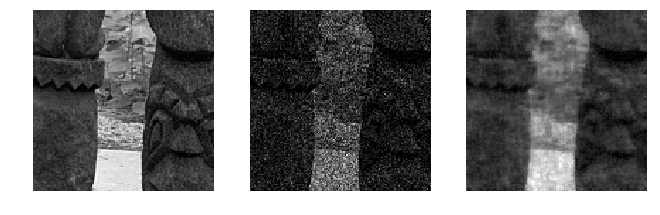

In [23]:
show([gt, noisy, model(noisy, noisy).detach()])

In [67]:
optimizer = Adam(model.parameters(), lr=1e-2)
optimizer.load_state_dict(state['optimizer_state_dict'])

criterion = th.nn.MSELoss()

In [25]:
th.get_rng_state()

tensor([77,  7, 52,  ...,  0,  0,  0], dtype=torch.uint8)